# Data Science
Training model
- Student: Dmytro Geleshko
- Group: IP-91
- Var: 6

# Imports

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

# Config

In [48]:
# var 6
np.random.seed(6)
plt.rcParams["figure.figsize"] = (20, 8)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.3f}".format

In [49]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load data

In [50]:
df = pd.read_csv("mod_data.csv", index_col="date", parse_dates=True, dtype=np.float32)
df

,close,volume,volume_norm,log_close,month_sin,month_cos,year_sin,year_cos
date,,,,,,,,
2010-07-18,0.100,80.000,-0.674,-2.303,-0.095,-0.995,-0.266,-0.964
2010-07-19,0.100,570.000,-0.672,-2.303,-0.297,-0.955,-0.283,-0.959
2010-07-20,0.100,260.000,-0.673,-2.303,-0.486,-0.874,-0.299,-0.954
2010-07-21,0.100,580.000,-0.672,-2.303,-0.655,-0.756,-0.316,-0.949
2010-07-22,0.100,"2,160.000",-0.666,-2.303,-0.796,-0.605,-0.332,-0.943
...,...,...,...,...,...,...,...,...
2021-11-21,"58,714.301","40,980.000",-0.523,10.980,-0.863,-0.505,-0.643,0.766
2021-11-22,"56,308.801","76,450.000",-0.392,10.939,-0.948,-0.317,-0.630,0.777
2021-11-23,"57,573.199","72,480.000",-0.406,10.961,-0.993,-0.116,-0.616,0.787


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4149 entries, 2010-07-18 to 2021-11-25
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        4149 non-null   float32
 1   volume       4149 non-null   float32
 2   volume_norm  4149 non-null   float32
 3   log_close    4149 non-null   float32
 4   month_sin    4149 non-null   float32
 5   month_cos    4149 non-null   float32
 6   year_sin     4149 non-null   float32
 7   year_cos     4149 non-null   float32
dtypes: float32(8)
memory usage: 162.1 KB


## Train/Test

In [52]:
# input: past 21 days
Tx = 21
# output: next 3 days
Ty = 3
# number of features
features = ["volume_norm", "log_close", "month_sin", "month_cos", "year_sin", "year_cos"]
n = len(features)
# size of train/test data
m = df.shape[0] - (Tx + Ty)

In [53]:
X = np.zeros((m, Tx, n))
y = np.zeros((m, Ty))

for i in range(m):
    X[i, :, :] = df[features].iloc[i:i+Tx].values
    y[i, :] = df["log_close"].iloc[i+Tx: i+Tx+Ty].values

X = X.astype(np.float32)
y = y.astype(np.float32)

X.shape, X.dtype, y.shape, y.dtype

((4125, 21, 6), dtype('float32'), (4125, 3), dtype('float32'))

In [54]:
batch_size = 64
train_size = int(X.shape[0] * 0.9)

In [55]:
X_train = X[:train_size, :, :]
y_train = y[:train_size, :]
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(X_train.shape[0])
train_dataset = train_dataset.batch(128)
train_dataset = train_dataset.prefetch(256)

X_test = X[train_size:, :, :]
y_test = y[train_size:, :]
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(128)
test_dataset = test_dataset.prefetch(256)

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print(train_dataset)

print("X_test", X_test.shape)
print("y_test", y_test.shape)
print(test_dataset)

X_train (3712, 21, 6)
y_train (3712, 3)
<PrefetchDataset shapes: ((None, 21, 6), (None, 3)), types: (tf.float32, tf.float32)>
X_test (413, 21, 6)
y_test (413, 3)
<PrefetchDataset shapes: ((None, 21, 6), (None, 3)), types: (tf.float32, tf.float32)>


# Models

## LSTM Neural Network

In [56]:
def create_lstm_model(Tx, n, Ty, learning_rate=0.01, decay=0.01):
    X_in = layers.Input(shape=(Tx, n))
    X = layers.LSTM(42, activation="relu", return_sequences=False)(X_in)
    X_out = layers.Dense(Ty)(X)

    model = tf.keras.Model(inputs=X_in, outputs=X_out)
    opt = tf.optimizers.Adam(learning_rate=learning_rate, decay=decay)
    model.compile(optimizer=opt, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanSquaredError()])

    return model

In [57]:
model_lstm = create_lstm_model(Tx, n, Ty, learning_rate=0.01, decay=0.002)
model_lstm.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 21, 6)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 42)                8232      
                                                                 
 dense_3 (Dense)             (None, 3)                 129       
                                                                 
Total params: 8,361
Trainable params: 8,361
Non-trainable params: 0
_________________________________________________________________


In [58]:
history = model_lstm.fit(train_dataset, validation_data=test_dataset, epochs=15)

Epoch 1/15
29/29 [==============================] - 2s 49ms/step - loss: 14.1546 - mean_squared_error: 14.1546 - val_loss: 2.1003 - val_mean_squared_error: 2.1003
Epoch 2/15
29/29 [==============================] - 1s 48ms/step - loss: 0.3386 - mean_squared_error: 0.3386 - val_loss: 0.1720 - val_mean_squared_error: 0.1720
Epoch 3/15
29/29 [==============================] - 1s 42ms/step - loss: 0.0721 - mean_squared_error: 0.0721 - val_loss: 0.0676 - val_mean_squared_error: 0.0676
Epoch 4/15
29/29 [==============================] - 1s 45ms/step - loss: 0.0365 - mean_squared_error: 0.0365 - val_loss: 0.0409 - val_mean_squared_error: 0.0409
Epoch 5/15
29/29 [==============================] - 1s 44ms/step - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 0.0371 - val_mean_squared_error: 0.0371
Epoch 6/15
29/29 [==============================] - 1s 47ms/step - loss: 0.0298 - mean_squared_error: 0.0298 - val_loss: 0.0333 - val_mean_squared_error: 0.0333
Epoch 7/15
29/29 [==============

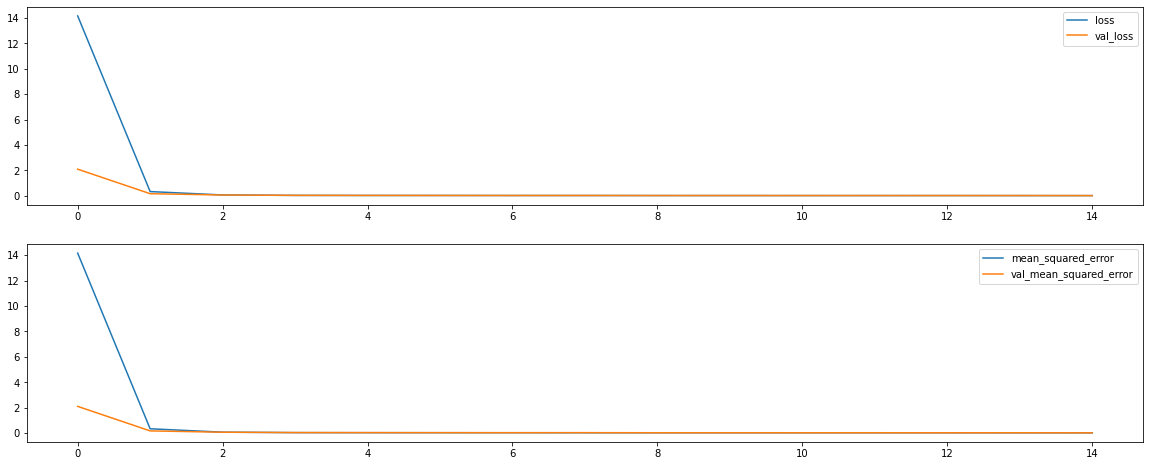

In [59]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(history.history["loss"], label="loss")
axes[0].plot(history.history["val_loss"], label="val_loss")
axes[0].legend()
axes[1].plot(history.history["mean_squared_error"], label="mean_squared_error")
axes[1].plot(history.history["val_mean_squared_error"], label="val_mean_squared_error")
axes[1].legend()
plt.show()

In [60]:
model_lstm.save("saved_model/v1_lstm.h5")

## Linear Regression with TensorFlow

In [61]:
def create_linear_model(Tx, n, Ty, learning_rate=0.01, decay=0.01):
    X_in = layers.Input(shape=(Tx, n))

    # (batch, time, n) -> (batch, time*n)
    X = layers.Reshape((Tx*n,))(X_in)
    
    # Dense layer with 1 neuron and no activation is the same as Linear Regression,
    # we will imitate Ty Linear Regressions stacked together.
    # They share same input features, but learn to predict price for different days.
    # Firt one will learn to forecast price on day t, second on day t + 1 and third on day t + 3
    X_out = layers.Dense(Ty)(X)

    model = tf.keras.Model(inputs=X_in, outputs=X_out)
    opt = tf.optimizers.Adam(learning_rate=learning_rate, decay=decay)
    model.compile(optimizer=opt, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanSquaredError()])

    return model

In [62]:
model_linear = create_linear_model(Tx, n, Ty, learning_rate=0.01, decay=0.002)
model_linear.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 21, 6)]           0         
                                                                 
 reshape_3 (Reshape)         (None, 126)               0         
                                                                 
 dense_4 (Dense)             (None, 3)                 381       
                                                                 
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________


In [63]:
history = model_linear.fit(train_dataset, validation_data=test_dataset, epochs=20)

Epoch 1/20
29/29 [==============================] - 0s 5ms/step - loss: 14.5757 - mean_squared_error: 14.5757 - val_loss: 1.2031 - val_mean_squared_error: 1.2031
Epoch 2/20
29/29 [==============================] - 0s 3ms/step - loss: 0.4130 - mean_squared_error: 0.4130 - val_loss: 0.2576 - val_mean_squared_error: 0.2576
Epoch 3/20
29/29 [==============================] - 0s 4ms/step - loss: 0.0818 - mean_squared_error: 0.0818 - val_loss: 0.0265 - val_mean_squared_error: 0.0265
Epoch 4/20
29/29 [==============================] - 0s 4ms/step - loss: 0.0492 - mean_squared_error: 0.0492 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 5/20
29/29 [==============================] - 0s 3ms/step - loss: 0.0439 - mean_squared_error: 0.0439 - val_loss: 0.0274 - val_mean_squared_error: 0.0274
Epoch 6/20
29/29 [==============================] - 0s 3ms/step - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0267 - val_mean_squared_error: 0.0267
Epoch 7/20
29/29 [====================

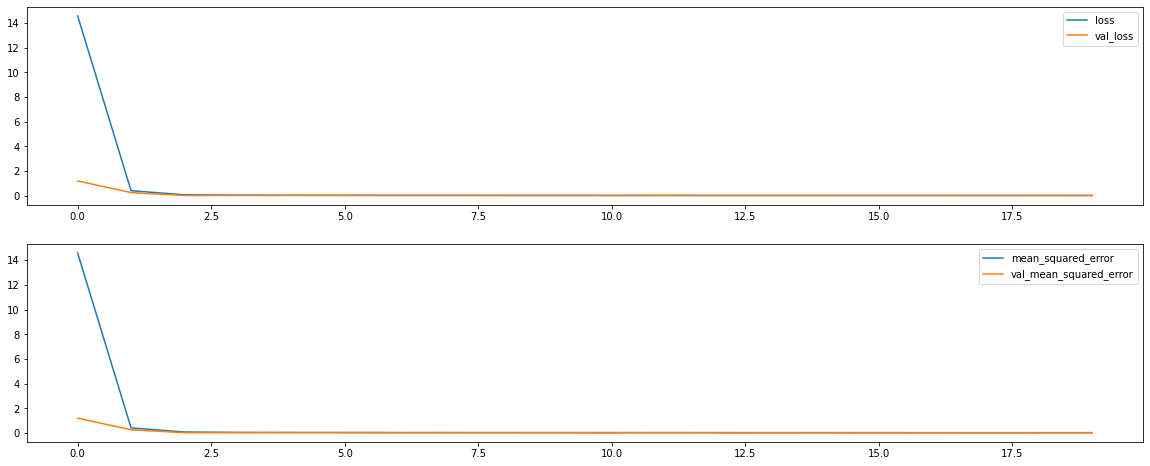

In [64]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(history.history["loss"], label="loss")
axes[0].plot(history.history["val_loss"], label="val_loss")
axes[0].legend()
axes[1].plot(history.history["mean_squared_error"], label="mean_squared_error")
axes[1].plot(history.history["val_mean_squared_error"], label="val_mean_squared_error")
axes[1].legend()
plt.show()

In [65]:
model_linear.save("saved_model/v1_linear.h5")